In [1]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [2]:
# 特徴量として総和を追加(面積)
# Elasticnet ransac

In [3]:
train = pd.read_csv('output.csv')

/Users/otomoryosuke/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
test = pd.read_csv('./data/test.csv')


In [5]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

df = pd.concat([train, test])
rm_cols += ['市区町村コード']
for i, v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [6]:
df.shape

(700543, 28)

In [7]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

In [8]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [9]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [10]:
test[TARGET] = np.nan
train.drop(rm_cols, axis=1, inplace=True)
test.drop(columns=rm_cols, axis=1, inplace=True)


In [11]:
# df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df = pd.concat([train, test])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [12]:
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [13]:
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [14]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

In [15]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [16]:

df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
# df['取引_建築'] = df['取引時点'].apply(lambda x: int(x[:4])) - df['建築年']
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
df.drop(['取引時点'], axis=1, inplace=True)


In [17]:
# 今後の利用目的と建物の構造を削除
df.drop(['今後の利用目的', '建物の構造'], axis=1, inplace=True)


In [18]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,用途,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,-1,-1,-1
1,1,1,1,1,1,0,0,0,-1


In [19]:
num_feature = [x for x in df.columns if df[x].dtype != 'object']
df[num_feature].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700543 entries, 0 to 700542
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            700543 non-null  int64  
 1   最寄駅：距離（分）     677413 non-null  float64
 2   面積（㎡）         700543 non-null  int64  
 3   建築年           680241 non-null  float64
 4   建ぺい率（％）       676793 non-null  float64
 5   容積率（％）        676793 non-null  float64
 6   取引価格（総額）_log  677392 non-null  float64
 7   取引時点_enc      700543 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 42.8 MB


In [20]:
cat_feature = [x for x in df.columns if df[x].dtype == 'object']
df[cat_feature]

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,用途,都市計画,改装,取引の事情等
0,神奈川県,横浜市南区,真金町,阪東橋,１Ｋ,住宅,NaN,NaN,NaN
1,東京都,中野区,中央,新中野,１ＬＤＫ,住宅,近隣商業地域,未改装,NaN
2,京都府,京都市伏見区,桃山町丹下,墨染,３ＬＤＫ,住宅,第１種住居地域,未改装,NaN
3,東京都,世田谷区,深沢,都立大学,３ＬＤＫ,住宅,第１種中高層住居専用地域,未改装,NaN
4,埼玉県,さいたま市緑区,原山,浦和,２ＬＤＫ,住宅,NaN,改装済,NaN
...,...,...,...,...,...,...,...,...,...
700538,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),３ＬＤＫ,住宅,第１種住居地域,未改装,NaN
700539,東京都,新宿区,中落合,落合南長崎,１Ｋ,NaN,近隣商業地域,未改装,NaN
700540,東京都,新宿区,中落合,落合南長崎,１Ｋ,住宅,近隣商業地域,改装済,NaN
700541,愛知県,名古屋市千種区,末盛通,覚王山,１ＬＤＫ,住宅,商業地域,NaN,NaN


In [21]:
def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）',
                                     ],
                        agg_methods=['count', 'mean']
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dis_2 = get_agg_df(df, group_col)
group_col1 = '都道府県名'
agg_dis_pre = get_agg_df(df, group_col1)

In [22]:
feat_df = pd.concat([df[num_feature], le_df, agg_dis_2, agg_dis_pre], axis=1)

In [23]:
feat_df['距離_bin'] = pd.cut(feat_df['最寄駅：距離（分）'], [0, 30, 45, 75, 120], labels=False)

In [24]:
nulti = feat_df['面積（㎡）'] * feat_df['容積率（％）']
feat_df['容積_面積'] = nulti

In [25]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名,市区町村名,...,用途,都市計画,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名,距離_bin,容積_面積
0,14198339,NaN,15,1992.0,NaN,NaN,6.698970,0,0,0,...,0,-1,-1,-1,3694,8.494857,95841,13.536514,NaN,NaN
1,13318874,NaN,40,1999.0,80.0,400.0,7.380211,0,1,1,...,0,0,0,-1,4524,6.402078,201943,7.800889,NaN,16000.0
2,26081806,4.0,60,1994.0,60.0,200.0,7.176091,0,2,2,...,0,1,0,-1,1908,9.590147,15959,10.065982,0.0,12000.0
3,13302280,NaN,85,2004.0,60.0,200.0,7.832509,0,1,3,...,0,2,0,-1,11256,8.792822,201943,7.800889,NaN,17000.0
4,11089836,NaN,50,1990.0,NaN,NaN,6.977724,0,3,4,...,0,-1,1,-1,548,19.826642,41539,13.331857,NaN,NaN


In [26]:
feat_df['距離'] = feat_df['agg_count_最寄駅：距離（分）_grpby_都道府県名'] / (feat_df['agg_count_最寄駅：距離（分）_grpby_市区町村名']+1)

In [28]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 24) (24899, 24) (23151, 24)


In [29]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [30]:
train_df.dropna(inplace=True)

/Users/otomoryosuke/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [35]:
from sklearn.preprocessing import StandardScaler
train_x= train_x.fillna(train_x.mean())

val_x = val_x.fillna(train_x.mean())

test_x = test_x.fillna(train_x.mean())

<AxesSubplot:>

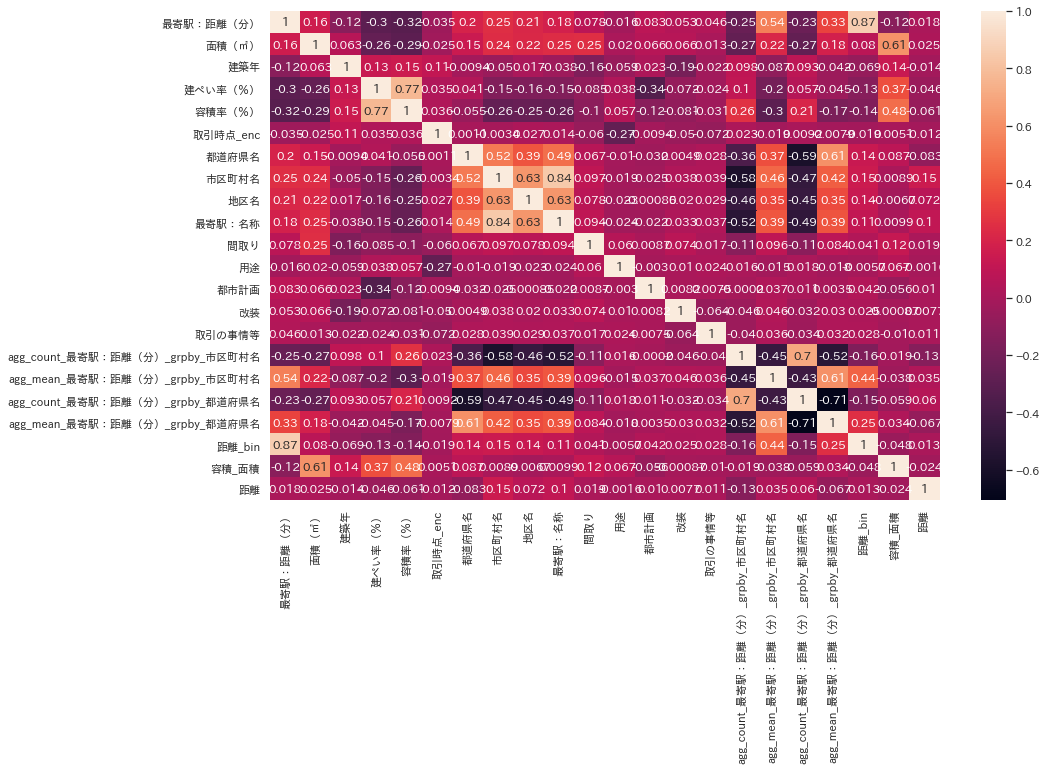

In [36]:
fig = plt.figure(figsize=(15,9))
sns.heatmap(train_x.corr(), annot=True)

In [37]:
train_x.head()

,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引時点_enc,都道府県名,市区町村名,地区名,最寄駅：名称,...,都市計画,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名,距離_bin,容積_面積,距離
2,4.0,60,1994.0,60.0,200.0,0,2,2,2,2,...,1,0,-1,1908,9.590147,15959,10.065982,0.0,12000.0,8.359874
6,6.0,65,1996.0,80.0,300.0,0,4,6,6,6,...,1,0,0,4716,5.699321,77417,9.218957,0.0,19500.0,16.412338
7,3.0,15,1984.0,60.0,200.0,0,1,3,7,7,...,2,0,-1,11256,8.792822,201943,7.800889,0.0,3000.0,17.939327
9,9.0,20,2005.0,80.0,400.0,0,1,8,9,9,...,3,0,-1,12280,7.819381,201943,7.800889,0.0,8000.0,16.443531
10,8.0,20,2005.0,60.0,300.0,0,1,9,10,10,...,4,0,-1,6862,5.421160,201943,7.800889,0.0,6000.0,29.424887


In [44]:
ela_ran = RANSACRegressor(ElasticNet(alpha=0.01,
                   l1_ratio=0.1
                        ),
                          max_trials=1000,
                          min_samples=50,
                          loss='absolute_loss',
                          residual_threshold=3,
                          random_state=0)
ela_ran.fit(train_x, train_y)
y_val = ela_ran.predict(val_x)

In [45]:
from sklearn.metrics import mean_absolute_error as mae
mae(val_y, y_val)

0.14133895222804965

In [46]:
ela_ran.estimator_.coef_

array([-4.27944767e-03,  8.88476804e-03,  1.32000631e-02, -1.15769238e-05,
        2.02186376e-04,  9.36102358e-04, -4.19394312e-03,  2.93866757e-05,
       -2.90514761e-06, -4.04927739e-05, -2.96779051e-03, -2.96956797e-02,
       -2.14322840e-05,  4.61243420e-02, -8.29802985e-02,  8.81261111e-06,
       -1.72722256e-03,  1.59029801e-06,  6.82986882e-03,  4.79865352e-02,
       -6.84978270e-07, -3.06041955e-04])

In [47]:
coef_df = pd.DataFrame({'columns': train_x.columns, 'value': ela_ran.estimator_.coef_})
coef_df

,columns,value
0,最寄駅：距離（分）,-4.279448e-03
1,面積（㎡）,8.884768e-03
2,建築年,1.320006e-02
3,建ぺい率（％）,-1.157692e-05
4,容積率（％）,2.021864e-04
5,取引時点_enc,9.361024e-04
6,都道府県名,-4.193943e-03
7,市区町村名,2.938668e-05
8,地区名,-2.905148e-06
9,最寄駅：名称,-4.049277e-05


In [48]:
inlier_mask = ela_ran.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
# line_X = np.arange(3, 12, 1)
line_y_ransac = ela_ran.predict(train_x)

# plt.scatter(val_y[inlier_mask], val_y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers')
# plt.scatter(val_y[outlier_mask], val_y[outlier_mask], c='orange', edgecolor='white', marker='s', label='liers')

# # plt.plot(line_X, line_y_ransac, color='black', lw=2)
# plt.xlabel('')


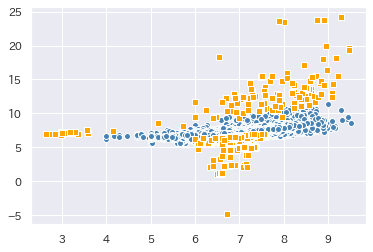

In [49]:

plt.scatter(train_y[inlier_mask], line_y_ransac[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers')
plt.scatter(train_y[outlier_mask], line_y_ransac[outlier_mask], c='orange', edgecolor='white', marker='s', label='liers')

In [50]:
len(train_y[outlier_mask]), len(train_y[inlier_mask])

(570, 596823)

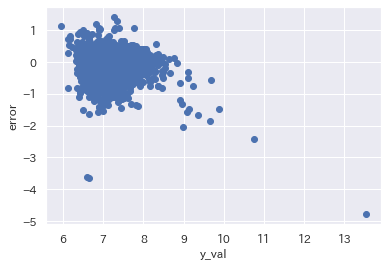

In [51]:
plt.scatter(y_val, val_y - y_val)
plt.xlabel('y_val')
plt.ylabel('error')
plt.show()

# ransac_elasticで学習したときの残差プロット
# 外れ値に対する予測が精度が下がっている

In [52]:
test_pred = ela_ran.predict(test_x)

test_df[TARGET] = test_pred

/Users/otomoryosuke/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


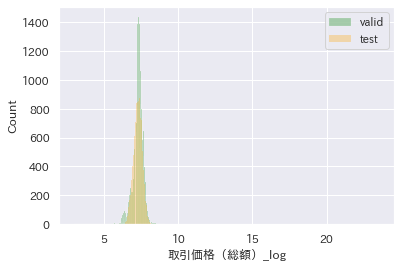

In [53]:
sns.histplot(val_y, color='green', alpha=0.3, label='valid')
sns.histplot(test_pred, color='orange', alpha=0.3, label='test')
plt.legend()